## Zadání ##

Řešíme kontaktní úlohu
$$\begin{gather*}
    -\Delta u = f(x, y) \quad \text{ na } \Omega, \\
    u = 0 \quad \text{ na } \Gamma_{D}, \\
    \frac{du}{dn}(x, y) = h(x, y) \quad \text{ na } \Gamma_{N}, \\
    u - g \geq 0 \quad \text{ na }  \Gamma_{C} \\
    \frac{du}{dn} \geq 0 \quad \text{ na }  \Gamma_{C} \\
    \frac{du}{dn}(u - g) = 0 \quad \text{ na }  \Gamma_{C},
\end{gather*}$$
kde
$$\begin{gather*}
    \Omega = \{ (x, y) \in \mathbb{R}^2 : |x| < 1 \land |y| < 1 \} \\
    \Gamma_{D} = \{ (x, y) \in \Omega : y = 1 \} \\
    \Gamma_{N} = \{ (x, y) \in \Omega : |x| = 1 \} \\
    \Gamma_{C} = \{ (x, y) \in \Omega : y = -1 \} \\ 
    f(x, y) = -1 \\
    g(x, y) = \sqrt{\frac{1}{2} - x^2} - \frac{\sqrt{2}}{2} - \frac{3}{5} \\
    h(x, y) = 0
\end{gather*}$$

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# imports
import torch
from torch.utils.data import DataLoader, TensorDataset
from typing import List
import sys
sys.path.append('../')

In [32]:
# vlastni import
import src.data.square_domain as sq
from src.models.mlp_model import MLPModel
from src import utils
from src import train
from src import calculus as calc

In [33]:
# vyber device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# funkce

def f(x: torch.Tensor) -> torch.Tensor:
    return -1

def h(x: torch.Tensor) -> torch.Tensor:
    return 0

def g(x: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(torch.clamp(0.5 - torch.pow(x[:, 0:1], 2), min=0.0)) - torch.sqrt(torch.tensor(2.0))/2 - 0.6

In [35]:
# definice loss

#TODO: vymyslet system pro smerove derivace

def loss_fn(model: torch.nn.Module, domain: sq.AbstractDomain):
    
    interior = domain.interior
    gamma_c = domain.bottom_boundary
    gamma_d = domain.top_boundary
    gamma_n_left = domain.left_boundary
    gamma_n_right = domain.right_boundary

    # prvne ztrata na vnitrku
    _, _, _, u_xx, u_yy = calc.compute_2nd_derivatives_2d(model, interior)
    int_loss = torch.mean((u_xx + u_yy - 1)**2)

    # ztrata dirchletovi podminky
    u = model(gamma_d)
    dirichlet_loss = torch.mean(u**2)

    #ztrata na neumannove podmince
    _, u_x_l, _ = calc.compute_derivatives_2d(model, gamma_n_left)
    _, u_x_r, _ = calc.compute_derivatives_2d(model, gamma_n_right)
    du_dn_n = torch.cat([-u_x_l, u_x_r], 0)
    neumann_loss = torch.mean((du_dn_n)**2)

    #ztrata na kontaktni podmince
    u, _, u_y = calc.compute_derivatives_2d(model, gamma_c)
    du_dn_c = -u_y
    u_minus_g = u - g(gamma_c)
    contact_loss_1 = torch.mean(torch.relu(-u_minus_g)**2)
    contact_loss_2 = torch.mean(torch.relu(-du_dn_c)**2)
    contact_loss_3 = torch.mean((du_dn_c * (u_minus_g))**2)
    
    contact_loss = contact_loss_1 + contact_loss_2 + contact_loss_3

   # print(int_loss, dirichlet_loss, neumann_loss, contact_loss)

    return int_loss + dirichlet_loss + neumann_loss + contact_loss

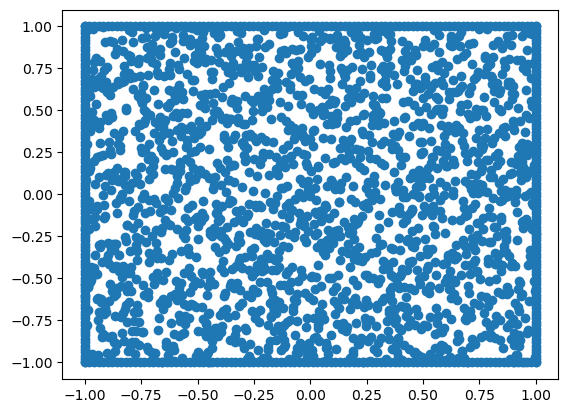

In [36]:
# definice domeny
config = sq.SquareDomainConfig(
    x_0=-1,
    x_1=1,
    y_0=-1,
    y_1=1,
    device=device,
    boundary_strategy='linear',
    interior_strategy='latin',
    N_int=2000,
)

domain = sq.SquareDomain(config)
utils.plot_domain(domain)

In [37]:
# definice modelu a optimalizatoru
model = MLPModel(2, 1, [20, 20, 20, 20, 20]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [38]:
# samotne trenovani
context = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=5_000
)

loss_values = train.train_switch_to_lbfgs(context, lbfgs_lr=0.1)

Loss at epoch 1 is: 1.0097005367279053
Loss at epoch 100 is: 0.07698336243629456
Loss at epoch 200 is: 0.03569274768233299
Loss at epoch 300 is: 0.02904333546757698
Loss at epoch 400 is: 0.023885317146778107
Loss at epoch 500 is: 0.018959717825055122
Loss at epoch 600 is: 0.015214383602142334
Loss at epoch 700 is: 0.01136582251638174
Loss at epoch 800 is: 0.007229621522128582
Loss at epoch 900 is: 0.005242650397121906
Loss at epoch 1000 is: 0.004108358174562454
Loss at epoch 1100 is: 0.0028517283499240875
Loss at epoch 1200 is: 0.0022571152076125145
Loss at epoch 1300 is: 0.0018857663962990046
Loss at epoch 1400 is: 0.0016798891592770815
Loss at epoch 1500 is: 0.0014233289984986186
Loss at epoch 1600 is: 0.0017444591503590345
Loss at epoch 1700 is: 0.0012905452167615294
Loss at epoch 1800 is: 0.0011946207378059626
Loss at epoch 1900 is: 0.0011100880801677704
Loss at epoch 2000 is: 0.0010943495435640216
Loss at epoch 2100 is: 0.0009876699186861515
Loss at epoch 2200 is: 0.00105887209065

/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


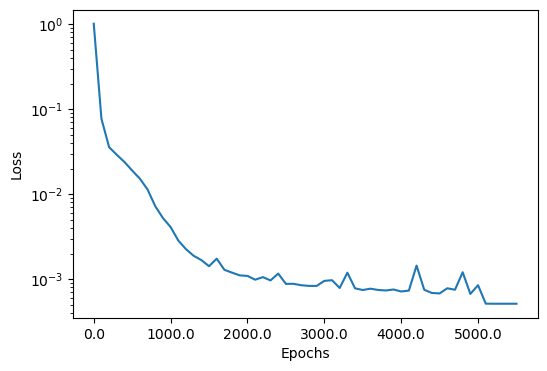

In [39]:
# vykresleni vyvoje ztraty
utils.plot_loss_values(values=loss_values, x_label='Epochs', y_label='Loss')

In [ ]:
plot_ctx = utils.PlotContext(
    function=model,
    domain=domain,
    patches=[]
)

utils.plot_function_on_domain(plot_ctx)

1000
